# Effects of Borrower Characteristics on Borrower APR and Probability of Defaulting on a Loan
## by Sarah Hazem

## Investigation Overview

> In this investigation, I wanted to look at the characteristics of borrowers that could be used to predict their borrower APR and the probability of a borrower defaulting on a loan. To do that, I added an extra "defaulted" binary feature where 1 indicates a customer has defaulted and 0 otherwise. The main focus was on the following characteristics: Prosper Rating, Loan Original Amount and Income Range.

## Dataset Overview

> The Prosper Loan Dataset consists of 113,937 loans with 81 variables for each loan. These variables the aforementioned characteristics in addition to other characteristics like debt to income ratio, loan category, occupation, and more. Over 29,000 entries were removed due to missing values in key characteristics.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.lines import Line2D

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan = pd.read_csv("prosperLoanData.csv")

In [3]:
#subsetting relevant variables to our analysis from the original dataset 
columns = ["ListingNumber", "ListingCreationDate", "LoanStatus", "BorrowerAPR", "ProsperRating (Alpha)",
           "ListingCategory (numeric)", "StatedMonthlyIncome", "ProsperScore", "IncomeRange",
         "EmploymentStatus", "Occupation", "DebtToIncomeRatio", "LoanOriginalAmount", "MonthlyLoanPayment"]
loan = loan[columns]

In [4]:
#dropping rows that have null values for prosper score
loan = loan[loan['ProsperScore'].notnull()]

In [5]:
#filling missing values in Occupation with unknown 
loan["Occupation"] = loan["Occupation"].astype(object).fillna("Other")
#filling missing values in debt to income ratio with the mean 
loan['DebtToIncomeRatio'].fillna((loan['DebtToIncomeRatio'].mean()), inplace=True)

In [6]:
#creating two new columns month and year by extracting them from the listing creation date column 
loan['year'] = loan['ListingCreationDate'].apply(lambda x: x.split("-")[0]).astype(str)
loan['month'] = loan['ListingCreationDate'].apply(lambda x: x.split("-")[1]).astype(str)
months = {'01':'JAN', '02': 'FEB', '03': 'MAR', '04': 'APR', '05':'MAY', '06': 'JUN','07': 'JUL',
         '08': 'AUG', '09': 'SEP', '10': 'OCT', '11': 'NOV', '12': 'DEC'}
loan['month']= loan['month'].map(months)
#dropping original listing creation date 
loan = loan.drop(['ListingCreationDate'], axis=1)

In [7]:
#setting mapping dictionary and mapping categories in listing category column from numeric values to string values 
category = {0:'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business',
          4:'Personal Loan', 5: 'Student Use', 6: 'Auto', 7: 'Other', 8: 'Baby & Adoption',
          9: 'Boat', 10: 'Cosmetic Procedure', 11: 'Engagement Ring', 12: 'Green Loans', 
         13: 'Household Expenses', 14 : 'Large Purchases', 15 : 'Medical/Dental', 16: 'Motorcycle',
         17 : 'RV', 18 : 'Taxes', 19 : 'Vacation', 20 : 'Wedding Loans'}
loan['category']= loan['ListingCategory (numeric)'].map(category)
#dropping original listing category column 
loan = loan.drop(['ListingCategory (numeric)'], axis=1)

In [8]:
#convert prosper rating, employment status, and month into ordered categorical types
ordinal_var_dict = {'ProsperRating (Alpha)': ['HR','E','D','C','B', 'A', 'AA'],
                   'EmploymentStatus': ['Employed', 'Self-Employed', 'Full-time', 'Part-time','Not employed',
                                        'Retired', 'Other'],
                    'month': ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT',
                             'NOV', 'DEC'],
                  'year': ['2009','2010', '2011', '2012', '2013', '2014'],
                   'IncomeRange': ['Not employed', '$0', '$1-24,999','$25,000-49,999','$50,000-74,999',
                                 '$75,000-99,999', '$100,000+']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    loan[var] = loan[var].astype(ordered_var)

In [9]:
#adding defaulting column
loan['defaulted'] = np.where(loan['LoanStatus']== 'Defaulted', 1, 0)
#renaming prosper rating column to lower case
loan.rename(columns={'ProsperRating (Alpha)':'prosper_rating'}, inplace=True)

## Distribution of Borrower APR

Borrower APR has a very small range of values, from about 0.05 at the lowest to 0.45 at the highest. 
Plotted on a normal scale, the distribution of Borrower APR takes on a multimodal shape.

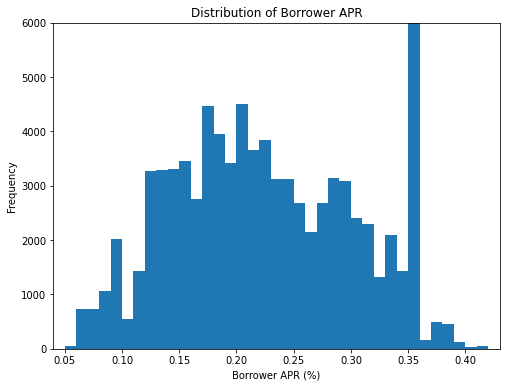

In [10]:
#plotting histogram for borrower APR
plt.figure(figsize=[8, 6])
bins = np.arange(0, loan['BorrowerAPR'].max()+0.05, 0.01)

plt.hist(data = loan, x = 'BorrowerAPR', bins = bins);
plt.xlim([0.04, 0.43]);
plt.ylim([0, 6000])
plt.xlabel('Borrower APR (%)');
plt.ylabel('Frequency')
plt.title("Distribution of Borrower APR");
plt.show()

## Distribution of Loan Original Amount

The Loan Original Amount is a variable indicating the original amount given to borrowers. Its values range from 1000 at the lowest to 35000 at the highest. The distribution is right-skewed with most common loan amount at 1000 with several peaks at 10,000, 15,000, and 25,000.

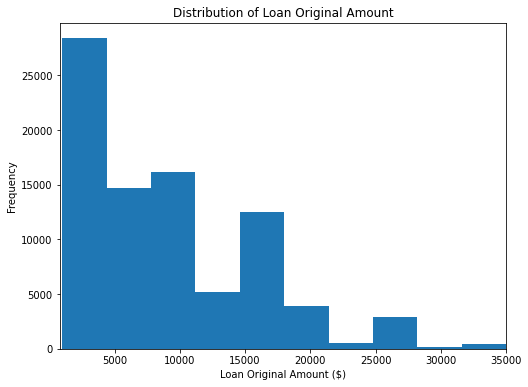

In [11]:
#plotting distribution of loan original amount
plt.figure(figsize=[8, 6])
plt.hist(data = loan, x = 'LoanOriginalAmount');
plt.xlim([800, 35000])
plt.xlabel('Loan Original Amount ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Original Amount');

## Borrower APR vs. Loan Original Amount
Plotting price Loan Original Amount vs. Borrower APR produces an approximately negative linear relationship. 

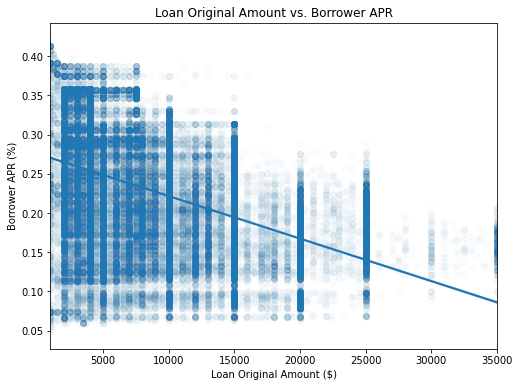

In [12]:
#plotting scatterplot with a regression fitted line
plt.figure(figsize=[8, 6])
sb.regplot(data = loan, x = 'LoanOriginalAmount', y = 'BorrowerAPR', scatter_kws={'alpha':1/50});
plt.xlabel('Loan Original Amount ($)');
plt.ylabel('Borrower APR (%)');
plt.title("Loan Original Amount vs. Borrower APR");

## Borrower APR vs. Prosper Rating
Customers are divided into 7 categories based on a measure called "Prosper Rating" ranging from H as the highest rating to AA at the lowest rating. Prosper rating indicates the level of risk associated with each customer, the higher the rating, the lower the risk. There is a negative correlation between Prosper Rating and Borrower APR, meaning the higher the rating, the lower the risk and the lower the borrower APR.

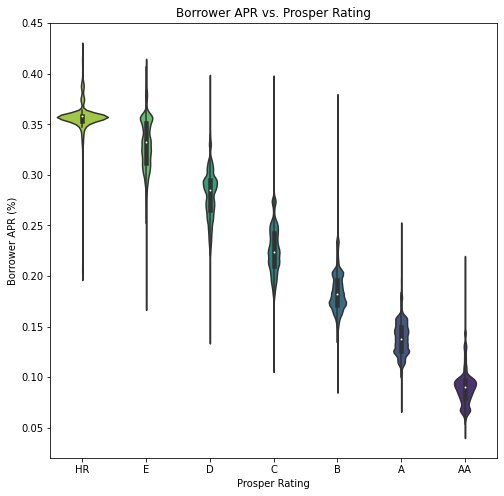

In [13]:
#plotting violin plot between borrower apr and prosper rating
plt.figure(figsize = [8, 8])

sb.violinplot(data=loan, x='prosper_rating', y='BorrowerAPR', palette = 'viridis_r');
plt.xlabel("Prosper Rating");
plt.ylabel("Borrower APR (%)");

plt.title("Borrower APR vs. Prosper Rating");

plt.show();

## Borrower APR vs. Income Range
Customers are divided into multiple income ranges with the lowest range at $0 and the highest range at 100,000+. There is a negative relationship between borrower APR and income range with the exception of people who are unemployed or have an income of zero, as the APR decreases gradually as income increases.

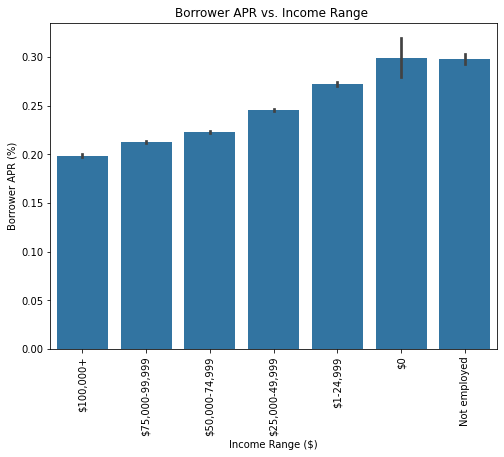

In [14]:
#plotting bar plot of APR vs income range 
base_color = sb.color_palette()[0]
plt.figure(figsize = [8, 6])
order = ['$100,000+', '$75,000-99,999', '$50,000-74,999', '$25,000-49,999', '$1-24,999','$0','Not employed' ]
sb.barplot(data=loan, x='IncomeRange', y='BorrowerAPR', color = base_color, order = order);
plt.xticks(rotation = 90);
plt.title("Borrower APR vs. Income Range ");
plt.xlabel("Income Range ($)");
plt.ylabel("Borrower APR (%)");

## Percentage of Defaulting vs. Non-Defaulting Customers

Customers have been divided into two categories: defaulted and did not default. The following pie chart shows the percentage of defaulting vs. non defaulting customers. 

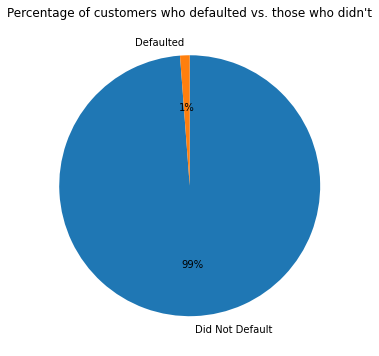

In [15]:
#pie chart for defaulted variable 
plt.figure(figsize=[8, 6])
values = loan['defaulted'].value_counts()
labels = ['Did Not Default', 'Defaulted']
plt.pie(values, labels = labels, startangle = 90, counterclock = False, autopct='%1.0f%%');
plt.title("Percentage of customers who defaulted vs. those who didn't");

## Percentage of Defaulting by Borrower APR and Loan Original Amount
The negative relationship between borrower APR and Loan Original Amount has already been established. By comparing that to the defaulting rate, we find that customers who defaulted had on average a higher APR and a lower loan original amount. 

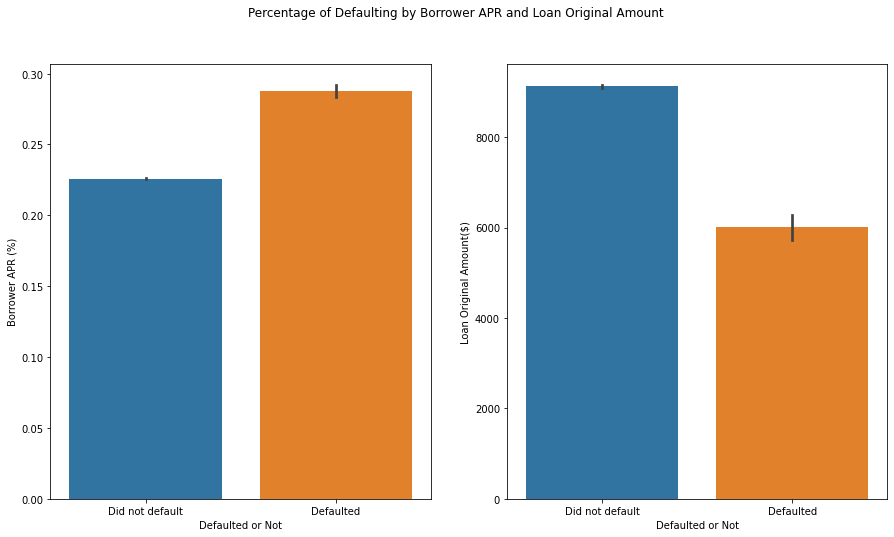

In [16]:
#Defaulting Across loan original amount and borrower apr 
fig, ax = plt.subplots(ncols = 2, figsize = [15,8])

sb.barplot(data=loan, x='defaulted', y='BorrowerAPR', ax = ax[0]);
ax[0].set_ylabel('Borrower APR (%)');
ax[0].set_xlabel("Defaulted or Not");
ax[0].set_xticklabels(['Did not default', 'Defaulted']);

sb.barplot(data=loan, x='defaulted', y='LoanOriginalAmount', ax = ax[1]);
ax[1].set_ylabel('Loan Original Amount($)');
ax[1].set_xlabel("Defaulted or Not");
ax[1].set_xticklabels(['Did not default', 'Defaulted']);
fig.suptitle('Percentage of Defaulting by Borrower APR and Loan Original Amount');

## Percentage of Defaulting by Prosper Rating and Income Range
The most common Prosper Rating for those who defaulted is a rating of D (a middle rating) and the most common Income Range for those who defaulted is an Income of $25,000-$49,999 (a middle income range). This is a very interesting discovery as its counterintuitive to our previous assumption that people with the lowest ratings and income ranges should have a higher rate of defaulting. 

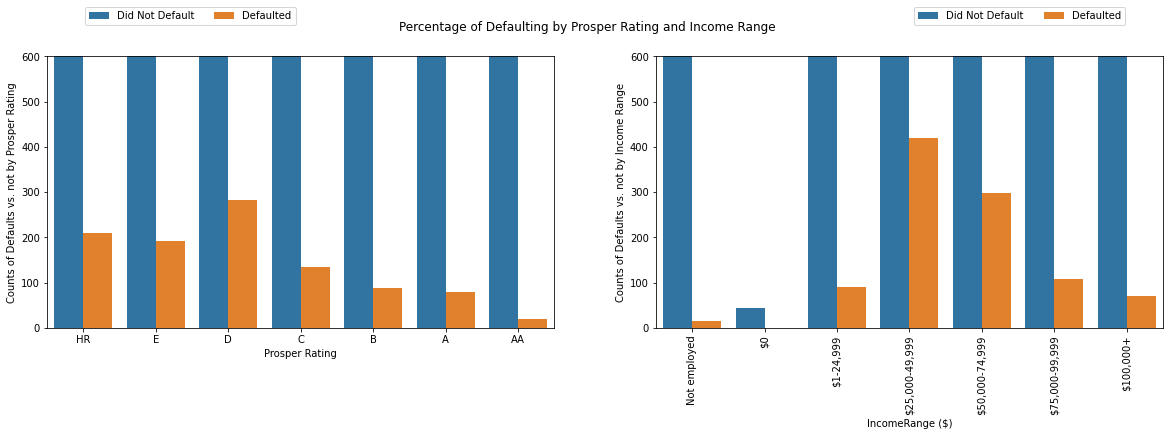

In [17]:
#plotting two clustered bar charts 
fig, ax = plt.subplots(ncols = 2, figsize = [20,5])

sb.countplot(data=loan, x='prosper_rating', hue='defaulted', ax = ax[0]);
ax[0].set_xlabel("Prosper Rating");
ax[0].set_ylabel("Counts of Defaults vs. not by Prosper Rating");
ax[0].set_ylim(0, 600)
ax[0].legend(['Did Not Default', 'Defaulted'], loc='upper right', bbox_to_anchor=(0.5, 1.2),ncol=2)


sb.countplot(data=loan, x='IncomeRange', hue='defaulted', ax = ax[1]);
ax[1].set_xlabel("IncomeRange ($)");
ax[1].set_ylim(0, 600)
plt.xticks(rotation = 90);
ax[1].set_ylabel("Counts of Defaults vs. not by Income Range");
ax[1].legend(['Did Not Default', 'Defaulted'], loc='upper left', bbox_to_anchor=(0.5, 1.2),ncol=2)

fig.suptitle('Percentage of Defaulting by Prosper Rating and Income Range');

## Borrower APR by Prosper Rating and Defaulting Rate
The evident approximately negative linear relationship between Borrower APR and Prosper Rating is emphasized by adding the defaulting parameter. On average, for each prosper rating, people who defaulted had a higher borrower APR.

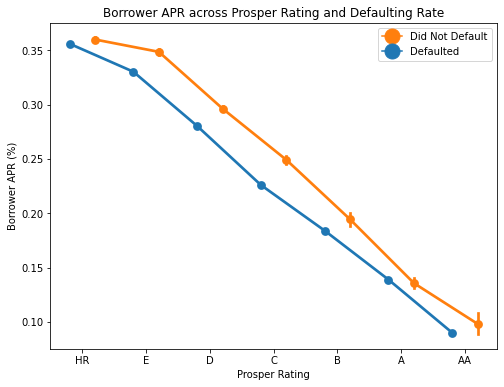

In [18]:
#plotting dodged point plot 
fig = plt.figure(figsize = [8,6])

legend_elements = [Line2D([0], [0], marker='o', color='tab:orange', label='Did Not Default', markersize=15),
                   Line2D([0], [0], marker='o', color='tab:blue', label='Defaulted', markersize=15)]

ax = sb.pointplot(data = loan, x = 'prosper_rating', y = 'BorrowerAPR', hue = 'defaulted', dodge = 0.4);

plt.title('Borrower APR across Prosper Rating and Defaulting Rate');
plt.legend(handles=legend_elements, loc ="upper right") 
plt.xlabel("Prosper Rating");
plt.ylabel("Borrower APR (%)");
plt.show();

## Borrower APR and Loan Original Amount By Prosper Rating for Customers Who Defaulted
Interestingly, by narrowing down our data into customers who defaulted, we can see that the previously negative relationship between Borrower APR and Loan Original Amount turns gradually into a positive relationship across all prosper ratings. However, the negative relationship between Borrower APR and prosper rating remains constant. This is probably because the occurrence of defaultings is correlated in opposite ways with Borrower APR and Loan Original Amount and their relationship is highly impacted by whether or not a customer has defaulted.

In [19]:
#dividing our df into defaulted and did not default 
defaulted = loan.loc[loan['defaulted'] == 1]
did_not = loan.loc[loan['defaulted'] == 0]

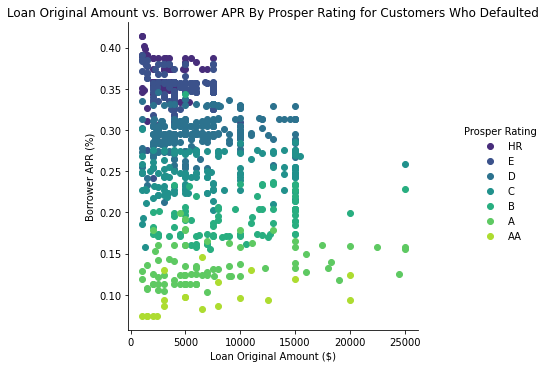

In [20]:
#plotting scatterplot
g = sb.FacetGrid(data= defaulted, hue = 'prosper_rating', size = 5, palette = 'viridis');
g.map(plt.scatter, 'LoanOriginalAmount', 'BorrowerAPR');
g.add_legend(title ="Prosper Rating");
plt.xlabel("Loan Original Amount ($)");
plt.ylabel("Borrower APR (%)");
plt.title("Loan Original Amount vs. Borrower APR By Prosper Rating for Customers Who Defaulted");